# Model Experimentation 3

In this next iteration, we will replace the ResNet-50 backbone with an implementation of darknet-19 and train it from scratch. This is to see if it was ResNet-50 that was simply unable to extract features from the waldo maps.

In [1]:
import IPython.core.display as di
from IPython.display import Markdown as md

def toggle_code():
    di.display_html(
        """<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">
            Toggle code
        </button>""",
        raw=True,
    )
    
def md_cat(file_path):
    with open(file_path) as file:
        return md(f"```python\n{file.read()}\n```")

toggle_code()

Toggle code

In [2]:
import json
import os
import sys
import logging
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as torchv
from matplotlib import patches
from PIL import Image
from tqdm.notebook import tqdm, trange

In [3]:
data_path = "../data"
sys.path.append(data_path)

In [4]:
from Dataset import Dataset, TestDataset, boxes
from LossAccumulator import LossAccumulator
from Parameters import Parameters

## Parameters

In [5]:
params = Parameters("params_v3.yml")

In [6]:
assert params.use_gpu

In [7]:
log = params.get_logger('Model_v3')

In [8]:
if not os.path.isdir(params.save_model_path):
    os.mkdir(params.save_model_path)

## Load Data

See the [data augmentation notebook](https://github.com/antoniojkim/WheresWaldo-YoloV3/blob/master/data/data.ipynb) for more details on how the data was curated and augmented.

In [9]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_inverse(y):
    return np.log(y/(1-y))

In [10]:
S = 12
B = 1
C = 1

class DatasetV3(Dataset):  # Same as DatasetV2
    
    @property
    def bounding_box_prior_width(self):
        return np.mean([d['box']['w'] for d in self.data if 'box' in d])
    
    @property
    def bounding_box_prior_height(self):
        return np.mean([d['box']['h'] for d in self.data if 'box' in d])
    
    def get_label(self, index, image):
        label = torch.zeros((S, S, B*5+C))
        if "box" in self.data[index]:
            image_c, image_h, image_w = image.shape
            
            box = self.data[index]["box"]            
            b_x, b_y, b_w, b_h = box["x"], box["y"], box["w"], box["h"]
            
            center_x = b_x + b_w // 2
            center_y = b_y + b_h // 2
            
            S_w = int(image.shape[2] // S)
            S_h = int(image.shape[1] // S)
            
            i = int(center_x // S_w)
            j = int(center_y // S_h)
            
            if i < S and j < S:
                t_x = (center_x - S_w * i) / S_w
                t_y = (center_y - S_h * j) / S_h
                t_w = np.log(b_w / self.bounding_box_prior_width)
                t_h = np.log(b_h / self.bounding_box_prior_height)

    #             print((t_x, t_y, t_w, t_h, 1, 1))
                label[i, j, :] = torch.tensor((t_x, t_y, t_w, t_h, 1, 1))
            
        return label

In [11]:
np.random.seed(20200501)
dataset = DatasetV3()
train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = True,
    drop_last   = True
)

In [12]:
test_dataloader = torch.utils.data.DataLoader(
    TestDataset(),
    batch_size  = params.batch_size,
    num_workers = params.num_workers,
    shuffle     = False,
    drop_last   = True
)

In [13]:
# test_image, test_label = next(iter(test_dataloader))
# test_image.shape

## Validation

In [14]:
def extract_prediction_box(images, prediction):
    confidences = prediction[0, :, :, -1] * prediction[0, :, :, -2]
    i, j = np.unravel_index(confidences.argmax(), confidences.shape)

    t_x, t_y, t_w, t_h, iou, c = prediction[0, i, j]
    n, image_c, image_h, image_w = images.shape
    S_w = int(image_w // (S - 1))
    S_h = int(image_h // (S - 1))
    b_w = int(dataset.bounding_box_prior_width * np.exp(t_w))
    b_h = int(dataset.bounding_box_prior_height * np.exp(t_h))
    b_x = int((t_x + i) * S_w - b_w // 2)
    b_y = int((t_y + j) * S_h - b_h // 2)
    return b_x, b_y, b_w, b_h

def validation(model, test_dataloader):
    with torch.no_grad():
        cumulative_IoU = 0
        for i, (images, labels) in enumerate(test_dataloader):
            images = to_device(images)
            output = model.forward(images)
            output = output.cpu().detach().numpy()
            
            b_x, b_y, b_w, b_h = extract_prediction_box(images, output)
            
            l_x, l_y, l_w, l_h = labels.detach().numpy()[0]
            
            x1 = max(b_x, l_x)
            y1 = max(b_y, l_y)
            x2 = min(b_x + b_w, l_x + l_w)
            y2 = min(b_y + b_h, l_y + l_h)

            intersection = max(x2 - x1, 0) * max(y2 - y1, 0)
            cumulative_IoU += intersection / (b_w * b_h + l_w * l_h - intersection)
            
        return cumulative_IoU / len(test_dataloader)

## Model Definition and Training

In [15]:
device = torch.device("cuda:"+params.cuda if params.use_gpu else "cpu")

def to_device(tensor):
    if params.use_gpu:
#         torch.nn.DataParallel(model).cuda()
#         tensor.cuda()
        return tensor.to(device)
    else:
        return tensor

In [16]:
# resnet = torchv.models.resnet50(pretrained=True)
# resnet = to_device(resnet)

# for param in resnet.parameters():
#     param.requires_grad = False

In [17]:
class ModelV3(torch.nn.Module):  # Implementation of Darknet-19
    
    def __init__(self):
        super().__init__()
        
        self.block1 = torch.nn.Sequential(
            self.Conv2dBatch(3, 32, kernel_size=3, stride=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = torch.nn.Sequential(
            self.Conv2dBatch(32, 64, kernel_size=3),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = torch.nn.Sequential(
            self.Conv2dBatch(64, 128, kernel_size=3),
            self.Conv2dBatch(128, 64, kernel_size=1),
            self.Conv2dBatch(64, 128, kernel_size=3),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = torch.nn.Sequential(
            self.Conv2dBatch(128, 256, kernel_size=3),
            self.Conv2dBatch(256, 128, kernel_size=1),
            self.Conv2dBatch(128, 256, kernel_size=3),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = torch.nn.Sequential(
            self.Conv2dBatch(256, 512, kernel_size=3),
            self.Conv2dBatch(512, 256, kernel_size=1),
            self.Conv2dBatch(256, 512, kernel_size=3),
            self.Conv2dBatch(512, 256, kernel_size=1),
            self.Conv2dBatch(256, 512, kernel_size=3),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block6 = torch.nn.Sequential(
            self.Conv2dBatch(512, 1024, kernel_size=3),
            self.Conv2dBatch(1024, 512, kernel_size=1),
            self.Conv2dBatch(512, 1024, kernel_size=3),
            self.Conv2dBatch(1024, 512, kernel_size=1),
            self.Conv2dBatch(512, 1024, kernel_size=3),
        )
        self.block7 = torch.nn.Sequential(
            self.Conv2dBatch(1024, 1000, 1),
            torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        )
        
        self.fc1 = torch.nn.Linear(1000, 4096)
        self.fc2 = torch.nn.Linear(4096, S*S*(B*5+C))
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        
        x = torch.flatten(x, 1)
        x = torch.nn.functional.softmax(x, dim=1)
        
        x = self.fc1(x)
        torch.nn.functional.relu(x, inplace=True)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x.reshape((-1, S, S, B*5+C))
    
    def __call__(self, x):
        return self.forward(x)
    
    def num_params(self):
        return sum([p.numel() for p in self.parameters() if p.requires_grad])
    
    @staticmethod
    def Conv2dBatch(in_channels, out_channels, kernel_size=3, stride=1, padding=1, **kwargs):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels  = in_channels,
                            out_channels = out_channels,
                            kernel_size  = kernel_size,
                            stride       = stride,
                            padding      = padding,
                            bias         = False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    
model = ModelV3()
model = to_device(model)

In [18]:
# images, labels = next(iter(train_dataloader))
# images = to_device(images)
# output = model.forward(images)

In [19]:
# load pretrained model if exists
if params.pretrained_model_path is not None and os.path.isfile(params.pretrained_model_path):
    print('loading model from %s ...' % params.pretrained_model_path)
    model.load_state_dict(torch.load(params.pretrained_model_path), strict=False)

loading model from ./.checkpoints/latest_model_v3.pt ...


In [20]:
optimizer = torch.optim.SGD(model.parameters(), params.learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer.zero_grad()

criterion = torch.nn.MSELoss()

In [21]:
best_mean_loss = np.inf
best_validation = -np.inf

for epoch in trange(params.epoch_start, params.num_epochs, leave=False):
    
    with tqdm(total=len(train_dataloader), position=0, leave=False) as progress, \
        LossAccumulator(optimizer, only4) as lossAccumulator:
        
        progress.set_description('epoch %d, lr %f' % (epoch, params.learning_rate))
        
        cumulative_loss = 0
        for i, (images, labels) in enumerate(train_dataloader):
            
            images = to_device(images)
            labels = to_device(labels)

            output = model.forward(images)
            loss = criterion(output.double(), labels.double())
            
            cumulative_loss += loss.item()
            info = f"Epoch {epoch}, lr {params.learning_rate}, i {i}, loss {loss.item()}"
            if np.isnan(loss.item()):
                log.warning(info)
                break
            else:
                log.info(info)
            
            loss.backward()

            progress.set_postfix(loss='%.6f' % loss.item())
            progress.update()

            next(lossAccumulator)

        if epoch % params.checkpoint_step == 0:
            torch.save(model.state_dict(),
                       os.path.join(params.save_model_path, 'latest_model_v3.pt'))
           
        mean_loss = cumulative_loss / len(train_dataloader)
        log.info(f"Epoch {epoch}, mean loss {mean_loss}")
        
        if mean_loss < best_mean_loss:
            best_mean_loss = mean_loss
            torch.save(model.state_dict(),
                       os.path.join(params.save_model_path, 'min_loss_model_v3.pt'))
           
        if epoch % params.validation_step == 0:
            mIoU = validation(model, test_dataloader)
            log.info(f"Epoch {epoch}, mIoU {mIoU}")
            if mIoU > best_validation:
                best_validation = mIoU
                torch.save(model.state_dict(),
                           os.path.join(params.save_model_path, 'best_model_v3.pt'))

torch.cuda.empty_cache()

In [22]:
torch.save(model.state_dict(),
           os.path.join(params.save_model_path, 'latest_model_v3.pt'))

## Validation

The loss metric was not very good and as such, I don't expect the model to be able to correctly guess the location of Waldo.

In [23]:
mIoU = validation(model, test_dataloader)
mIoU

0.0

In [24]:
images, labels = next(iter(test_dataloader))
images = to_device(images)
output = model.forward(images)
output = output.cpu().detach().numpy()

In [25]:
waldo_map = images.cpu().detach().numpy()
waldo_map = np.moveaxis(np.squeeze(waldo_map, axis=0), 0, -1)

In [26]:
confidences = output[0, :, :, -1] * output[0, :, :, -2]
i, j = np.unravel_index(confidences.argmax(), confidences.shape)

t_x, t_y, t_w, t_h, iou, c = output[0, i, j]
S_w = int(waldo_map.shape[1] // S)
S_h = int(waldo_map.shape[0] // S)
b_x = int((t_x + i) * S_w)
b_y = int((t_y + j) * S_h)
b_w = int(dataset.bounding_box_prior_width * np.exp(t_w))
b_h = int(dataset.bounding_box_prior_height * np.exp(t_h))

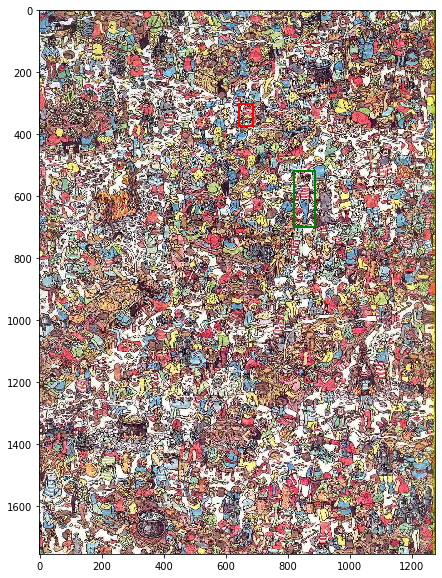

In [27]:
fig, ax = plt.subplots(1, figsize=(18, 10))
ax.imshow(waldo_map)
ax.add_patch(patches.Rectangle((b_x, b_y), b_w, b_h, linewidth=2, edgecolor='r', facecolor='none'))
x, y, w, h = labels.numpy()[0]
ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none'))
plt.show()

Although it may be hard to see in the above image, there is a red box (top center) which represents the prediction made by the model for where Waldo is on the map as well as a green box (top right) which represents Waldo's true location.

It is clear that the model is not performing all that well. I suspect now that is is because I am using ResNet-50 as the backbone. ResNet-50 was pretrained on ImageNet. The waldo maps are not what it was designed to extract features from.

We now move onto the next iteration of the model.

## Logs

We'll take a look at the logs to see if the model loss did indeed go down

In [28]:
with open(params.log_file) as file:
    model_logs = [line for line in file]

In [29]:
mean_loss_re = re.compile("Epoch (?P<epoch>[0-9]+), mean loss (?P<loss>[0-9]+.[0-9]+)")
mIoU_re = re.compile("Epoch (?P<epoch>[0-9]+), mIoU (?P<miou>[0-9]+.[0-9]+)")

In [30]:
mean_losses = []
mious = []
for line in model_logs:
    m = mean_loss_re.search(line)
    if m:
        mean_losses.append((int(m.group("epoch")), float(m.group("loss"))))
        
    m = mIoU_re.search(line)
    if m:
        mious.append((int(m.group("epoch")), float(m.group("miou"))))

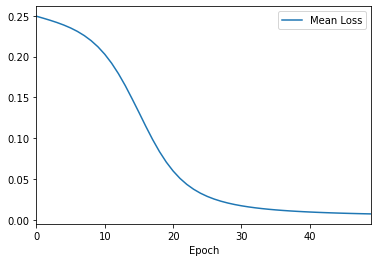

In [31]:
pd.DataFrame(mean_losses, columns=["Epoch", "Mean Loss"]).set_index("Epoch").plot()
plt.show()

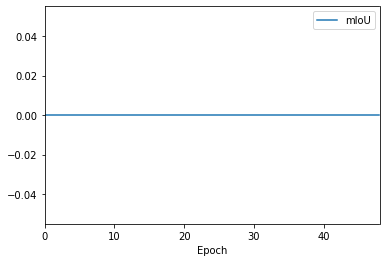

In [32]:
pd.DataFrame(mious, columns=["Epoch", "mIoU"]).set_index("Epoch").plot()
plt.show()

The model never achieved an mIoU greater than zero. This means that out model never improved despite the fact that the loss when down.